# Configure Phenotype Parameters

This notebook should be used as a test for ensuring correct phenotype image loading and processing before running phenotype module.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for phenotype processing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

## Imports

In [2]:
from pathlib import Path

import yaml
import numpy as np
from tifffile import imread
import matplotlib.pyplot as plt
from microfilm.microplot import Microimage

from lib.shared.configuration_utils import (
    CONFIG_FILE_HEADER,
    create_micropanel,
    random_cmap,
    image_segmentation_annotations,
)
from lib.shared.file_utils import get_filename
from lib.shared.illumination_correction import apply_ic_field
from lib.phenotype.align_channels import align_phenotype_channels
from lib.shared.segment_cellpose import estimate_diameters, segment_cellpose
from lib.shared.segment_microsam import segment_microsam
from lib.shared.segment_stardist import segment_stardist
from lib.phenotype.identify_cytoplasm_cellpose import (
    identify_cytoplasm_cellpose,
)
from lib.shared.extract_phenotype_minimal import extract_phenotype_minimal
from lib.phenotype.identify_vacuoles import segment_vacuoles, create_vacuole_boundary_visualization
from lib.phenotype.extract_phenotype_cp_multichannel import (
    extract_phenotype_cp_multichannel,
)
from lib.phenotype.extract_phenotype_vacuoles import extract_phenotype_vacuoles

2025-03-18 16:05:08.597245: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## <font color='red'>SET PARAMETERS</font>

### Parameters for testing phenotype processing

- `TEST_PLATE`, `TEST_WELL`, `TEST_TILE`: Plate/well/tile combination used for configuring parameters in this notebook.

### Channels
- `CHANNEL_NAMES`: A list of names for each channel in your phenotyping image. These names will be used in the output data frame to label the features extracted from each channel.
- `CHANNEL_CMAPS`: A list of color maps to use when showing channel microimages. These need to be a Matplotlib or microfilm colormap. We recommend using: `["pure_red", "pure_green", "pure_blue", "pure_cyan", "pure_magenta", "pure_yellow"]`.

### Feature Extraction

- `FOCI_CHANNEL`: Determines which channel is used for foci detection. This should be set to the index of the channel containing the marker you want to detect foci for.

In [3]:
# parameters for testing
TEST_PLATE = 1
TEST_WELL = "A1"
TEST_TILE = 1
WILDCARDS = dict(well=TEST_WELL, tile=TEST_TILE)

CHANNEL_NAMES = ["DAPI", "ConA", "Mitotracker", "CDPK1", "Stat6", "DAPI2", "Tubulin", "cMyc", "WGA", "NHS-Ester"]
CHANNEL_CMAPS = ["pure_blue", "pure_green", "pure_red", "pure_yellow", "pure_cyan", "pure_blue", "pure_green", "pure_red", "pure_yellow", "pure_cyan"]

# parameters for feature extraction
FOCI_CHANNEL = 3

Loading test image...
Applying illumination correction...
Example corrected image:


microplot.py (725): Ignoring specified arguments in this call because figure with num: 1 already exists


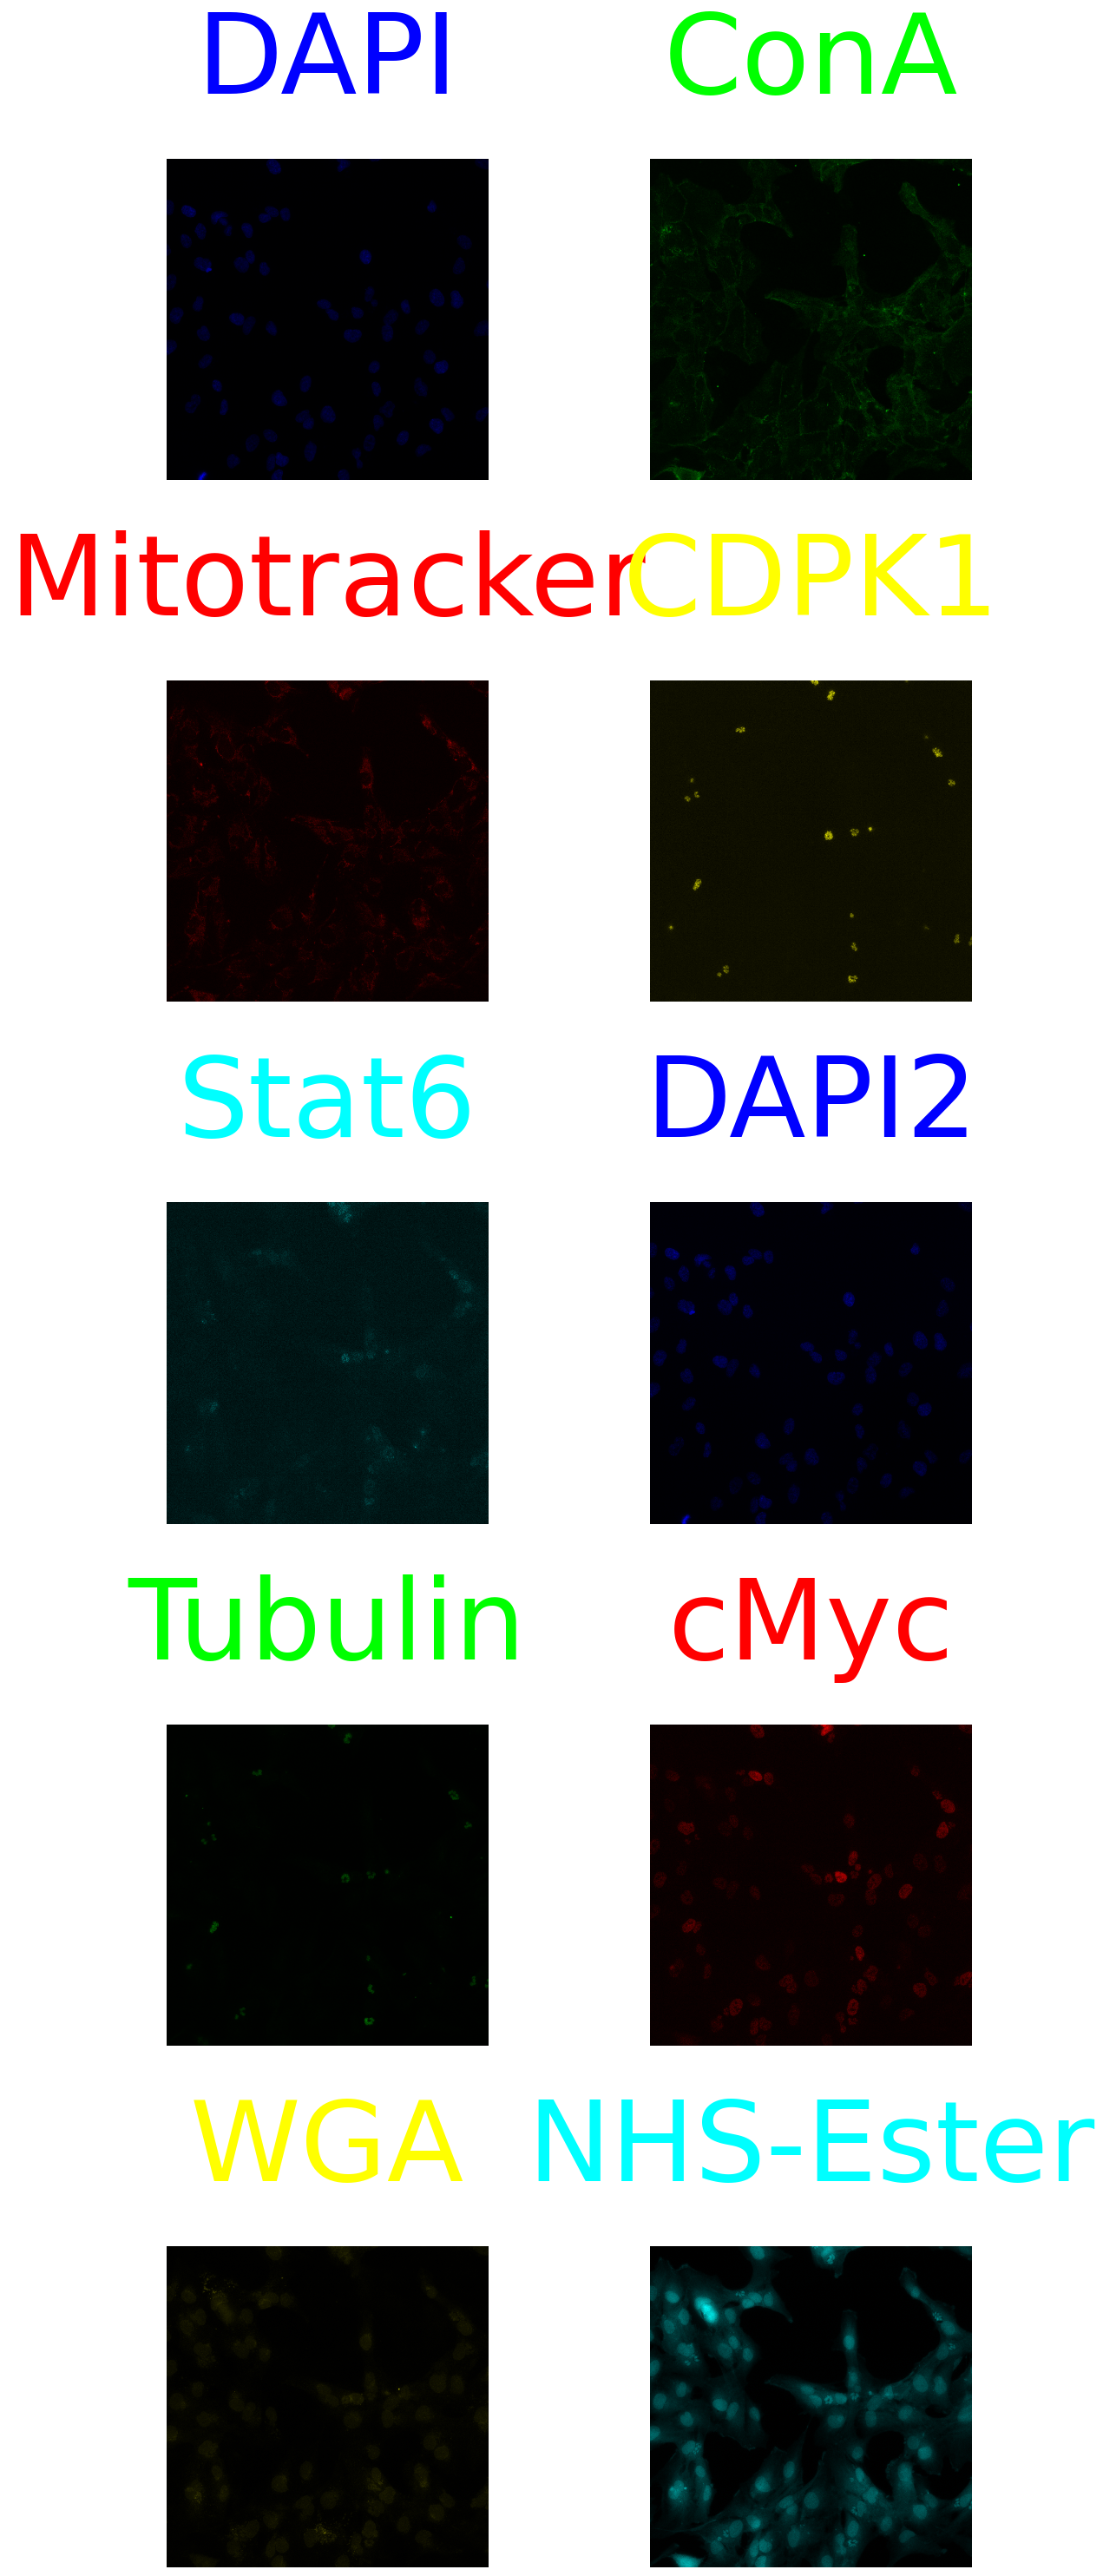

In [4]:
# load config file
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)

# load test image data
print("Loading test image...")
ROOT_FP = Path(config["all"]["root_fp"])
PREPROCESS_FP = ROOT_FP / "preprocess"
phenotype_test_image_path = str(
    PREPROCESS_FP
    / "images"
    / "phenotype"
    / get_filename(
        {"plate": TEST_PLATE, "well": TEST_WELL, "tile": TEST_TILE},
        "image",
        "tiff",
    )
)
phenotype_test_image = imread(phenotype_test_image_path)

print("Applying illumination correction...")
# Read the illumination correction file
ic_field_path = str(
    PREPROCESS_FP
    / "ic_fields"
    / "phenotype"
    / get_filename({"plate": TEST_PLATE, "well": TEST_WELL}, "ic_field", "tiff")
)
ic_field = imread(ic_field_path)

# This corresponds to the 'apply_illumination_correction' rule in Snakemake
corrected_image = apply_ic_field(phenotype_test_image, correction=ic_field)

# Create and display micropanel of corrected images
print("Example corrected image:")
corrected_microimages = [
    Microimage(
        corrected_image[i], channel_names=CHANNEL_NAMES[i], cmaps=CHANNEL_CMAPS[i]
    )
    for i in range(corrected_image.shape[0])
]
corrected_panel = create_micropanel(corrected_microimages, add_channel_label=True)
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Aligning (optional)

- `ALIGN`: Whether to conduct alignment. This is suggested **unless** each image is captured with each channel consecutively. 
- `TARGET`: Index of the channel that other channels will be aligned to.
- `SOURCE`: Index of the channel to align with the target.
- `RIDERS`: Additional channel indices that should follow the same alignment as the source channel.
- `REMOVE_CHANNEL`: Specifies whether to remove channels after alignment. In the case of duplicate channels that are used to align the image, should be set to `source`.

In [5]:
# Set alignment parameters
ALIGN = True
TARGET = "DAPI"
SOURCE = "DAPI2"
RIDERS = ["Tubulin", "cMyc", "WGA", "NHS-Ester"]
REMOVE_CHANNEL = "source"

# Derive alignment indexes
if ALIGN:
    TARGET_INDEX = CHANNEL_NAMES.index(TARGET)
    SOURCE_INDEX = CHANNEL_NAMES.index(SOURCE)
    RIDER_INDEXES = [CHANNEL_NAMES.index(r) for r in RIDERS]

In [6]:
if ALIGN:
    print("Aligning channels...")
    aligned_image = align_phenotype_channels(
        corrected_image,
        target=TARGET_INDEX,
        source=SOURCE_INDEX,
        riders=RIDER_INDEXES,
        remove_channel=REMOVE_CHANNEL,
    )
else:
    aligned_image = corrected_image

Aligning channels...


In [7]:
# Remove source index from channel names and cmaps
CHANNEL_NAMES.pop(SOURCE_INDEX)
CHANNEL_CMAPS.pop(SOURCE_INDEX)

CHANNEL_NAMES, CHANNEL_CMAPS

(['DAPI',
  'ConA',
  'Mitotracker',
  'CDPK1',
  'Stat6',
  'Tubulin',
  'cMyc',
  'WGA',
  'NHS-Ester'],
 ['pure_blue',
  'pure_green',
  'pure_red',
  'pure_yellow',
  'pure_cyan',
  'pure_green',
  'pure_red',
  'pure_yellow',
  'pure_cyan'])

## <font color='red'>SET PARAMETERS</font>

### Segmentation

#### Select Segmentation Method
- `SEGMENTATION_METHOD`: Choose from "cellpose", "microsam", or "stardist" for cell segmentation.

#### Common Parameters
- `CYTO_CHANNEL`: Channel to use for cell detection (typically "PHALLOIDIN")
- `GPU`: Set to True to use GPU acceleration (if available)
- `RECONCILE`: Method for reconciling nuclei and cell masks (typically "contained_in_cells", which allows more than one nucleus per cell and is useful for cells that are dividing)

#### Cellpose Parameters (if using "cellpose")
- `CELLPOSE_MODEL`: CellPose model to use ("cyto", "cyto2", or "cyto3"). Default is "cyto3".
- `FLOW_THRESHOLD`: Flow threshold for Cellpose segmentation. Default is 0.4.
- `CELLPROB_THRESHOLD`: Cell probability threshold for Cellpose. Default is 0.
- Note: Nuclei and cell diameters will be estimated automatically.

#### MicroSAM Parameters (if using "microsam")
- `MICROSAM_MODEL`: MicroSAM model type. Default is "vit_b_lm".
- `POINTS_PER_SIDE`: Number of points to sample along each side of the image. Default is 32.
- `POINTS_PER_BATCH`: Number of points to process in one batch. Default is 16.
- `STABILITY_SCORE_THRESH`: Threshold for stability score. Default is 0.95.
- `PRED_IOU_THRESH`: Threshold for predicted IoU. Default is 0.88.

#### StarDist Parameters (if using "stardist")
- `STARDIST_MODEL`: StarDist model type. Default is "2D_versatile_fluo".
- `PROB_THRESH`: Probability threshold for segmentation. Default is 0.479071.
- `NMS_THRESH`: Non-maximum suppression threshold. Default is 0.3.

Note: You may want to adjust these parameters and run segmentation tests if you feel you are capturing too little or too much area for the masks. For cellpose, the nuclei and cell diameters will be automatically estimated, but can be manually adjusted if needed.

In [8]:
# Common parameters
CYTO_CHANNEL = "ConA"
GPU = False
RECONCILE = "contained_in_cells"
DAPI_INDEX = CHANNEL_NAMES.index("DAPI")
CYTO_INDEX = CHANNEL_NAMES.index(CYTO_CHANNEL)

# Select segmentation method
SEGMENTATION_METHOD = "cellpose"

if SEGMENTATION_METHOD == "cellpose":
    # Parameters for CellPose method
    CELLPOSE_MODEL = "cyto3"
    FLOW_THRESHOLD = 0.4
    CELLPROB_THRESHOLD = 0

    print("Estimating optimal cell and nuclei diameters...")
    NUCLEI_DIAMETER, CELL_DIAMETER = estimate_diameters(
        corrected_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        cyto_model=CELLPOSE_MODEL,
    )

elif SEGMENTATION_METHOD == "microsam":
    # Parameters for MicroSAM method
    MICROSAM_MODEL = "vit_b_lm"
    POINTS_PER_SIDE = 32
    POINTS_PER_BATCH = 16
    STABILITY_SCORE_THRESH = 0.95
    PRED_IOU_THRESH = 0.88

elif SEGMENTATION_METHOD == "stardist":
    # Parameters for StarDist method
    STARDIST_MODEL = "2D_versatile_fluo"
    PROB_THRESH = 0.479071
    NMS_THRESH = 0.3

Estimating optimal cell and nuclei diameters...


dtype.py (576): Downcasting uint16 to uint8 without scaling because max value 0 fits in uint8
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.models:>> nuclei << model set to be used
INFO:cellpose.models:>>>> loading model /home/mdiberna/.cellpose/models/nucleitorch_0


Estimating nuclei diameters...


INFO:cellpose.models:>>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.models:>> cyto3 << model set to be used
INFO:cellpose.models:>>>> loading model /home/mdiberna/.cellpose/models/cyto3


Estimated nuclear diameter: 95.7 pixels
Estimating cell diameters...


INFO:cellpose.models:>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)


Estimated cell diameter: 108.8 pixels


In [9]:
# Manually set cell diameter to 300
CELL_DIAMETER = 300

Segmenting image with cellpose...


INFO:cellpose.core:>>>> using CPU
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.models:>> nuclei << model set to be used
INFO:cellpose.models:>>>> loading model /home/mdiberna/.cellpose/models/nucleitorch_0
INFO:cellpose.models:>>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.models:>> cyto3 << model set to be used
INFO:cellpose.models:>>>> loading model /home/mdiberna/.cellpose/models/cyto3
INFO:cellpose.models:>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
INFO:cellpose.models:channels set to [3, 0]
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 36.65 sec
INFO:cellpose.models:channels set to [2, 3]
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 270.49 sec
found 80 nuclei before removing edges
found 75 cells before removing edges


removing edges


found 66 nuclei before reconciling
found 58 cells before reconciling


reconciling masks with method how=contained_in_cells

Nuclei per cell statistics:
--------------------------
Cells with 0 nuclei: 4
Cells with 1 nuclei: 52
Cells with 2 nuclei: 2
--------------------------



found 54 nuclei/cells after reconciling


Number of nuclei segmented: 54
Number of cells segmented: 54
Example microplots for DAPI channel and nuclei segmentation:


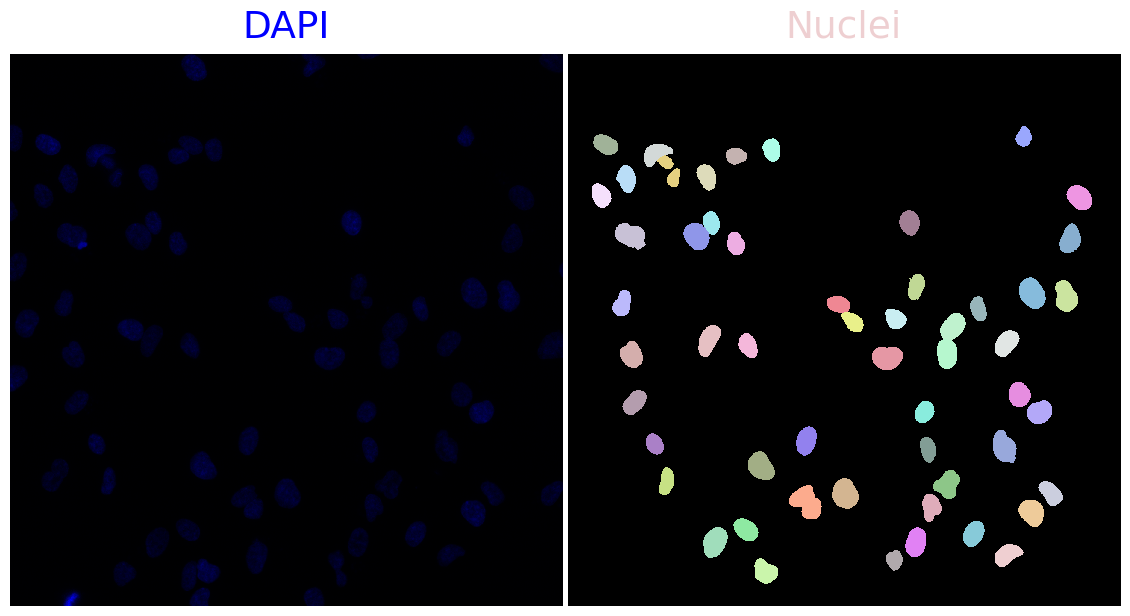

Example microplots for merged channels and cells segmentation:


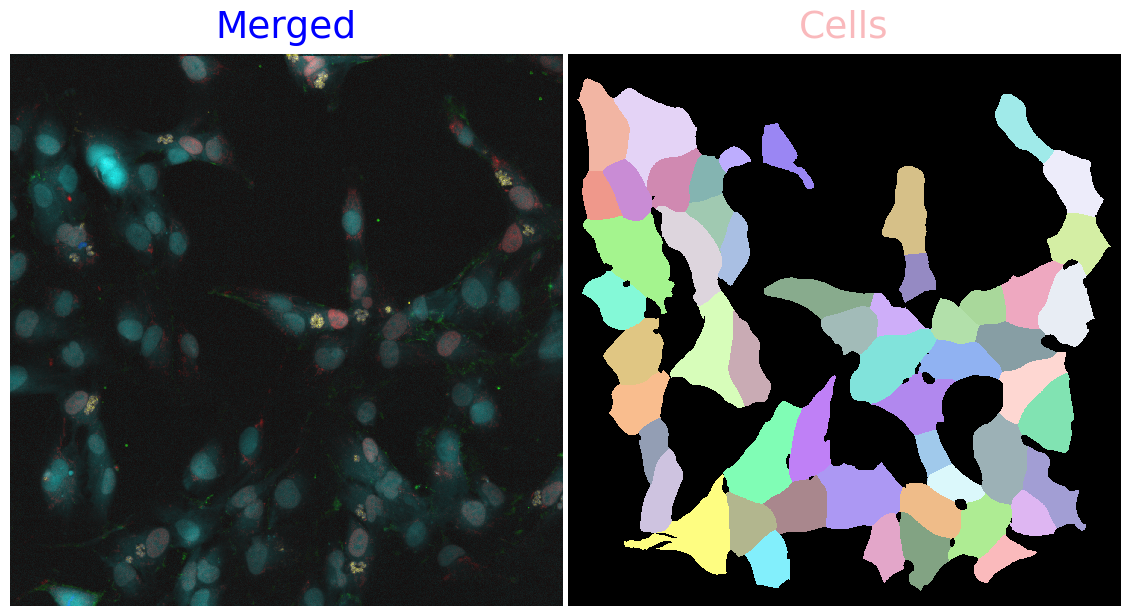

Example microplot for phenotype data annotated with segmentation:


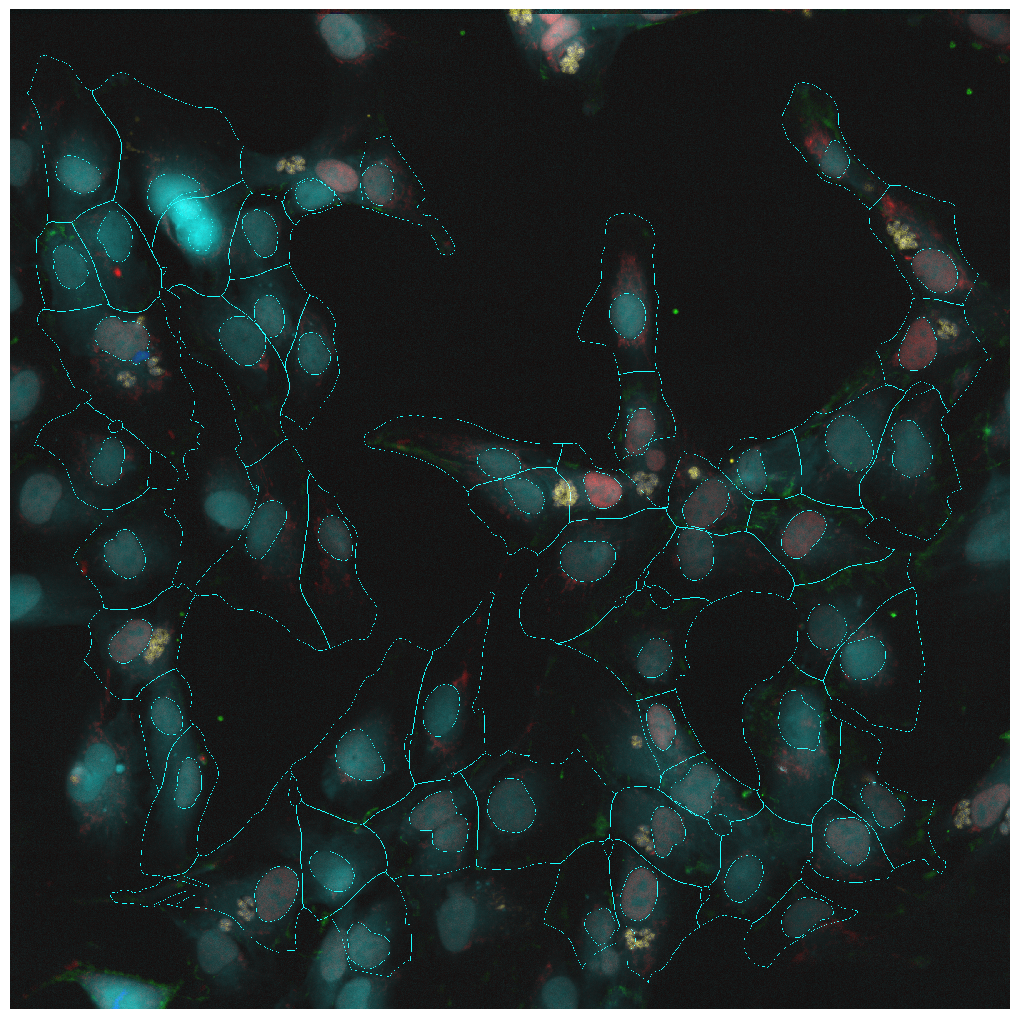

Example microplots for cytoplasms relative to nuclei:
Number of cytoplasms identified: 54


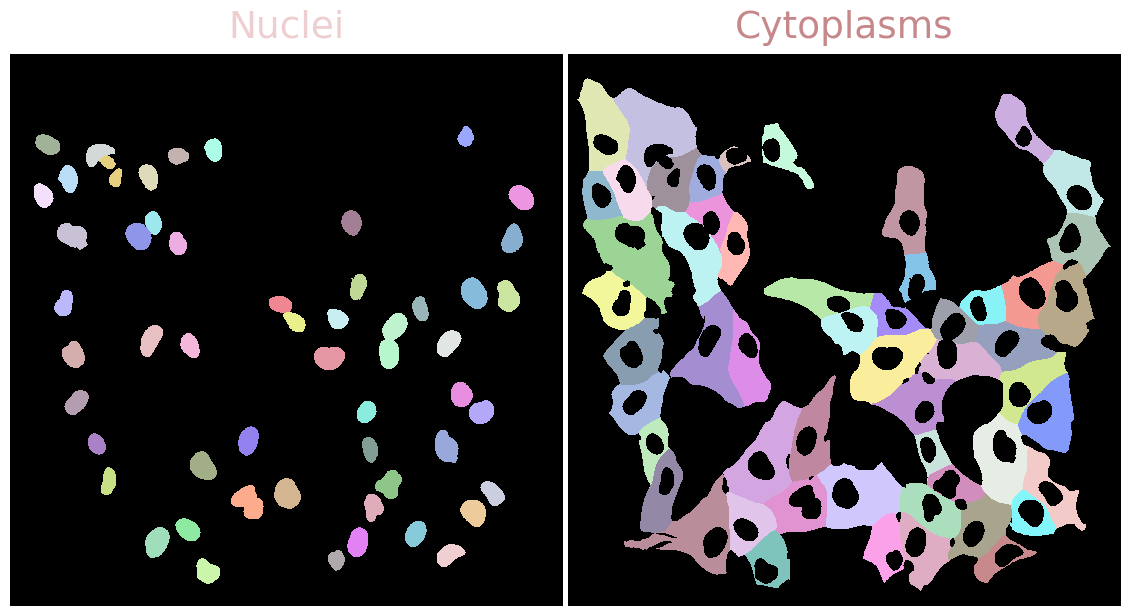

In [10]:
print(f"Segmenting image with {SEGMENTATION_METHOD}...")

if SEGMENTATION_METHOD == "cellpose":
    nuclei, cells = segment_cellpose(
        corrected_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        nuclei_diameter=NUCLEI_DIAMETER,
        cell_diameter=CELL_DIAMETER,
        cellpose_kwargs=dict(
            flow_threshold=FLOW_THRESHOLD,
            cellprob_threshold=CELLPROB_THRESHOLD,
        ),
        cyto_model=CELLPOSE_MODEL,
        gpu=GPU,
        reconcile=RECONCILE,
    )

elif SEGMENTATION_METHOD == "microsam":
    nuclei, cells = segment_microsam(
        corrected_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        model_type=MICROSAM_MODEL,
        microsam_kwargs=dict(
            points_per_side=POINTS_PER_SIDE,
            points_per_batch=POINTS_PER_BATCH,
            stability_score_thresh=STABILITY_SCORE_THRESH,
            pred_iou_thresh=PRED_IOU_THRESH,
        ),
        gpu=GPU,
        reconcile=RECONCILE,
    )

elif SEGMENTATION_METHOD == "stardist":
    nuclei, cells = segment_stardist(
        corrected_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        model_type=STARDIST_MODEL,
        stardist_kwargs=dict(
            prob_thresh=PROB_THRESH,
            nms_thresh=NMS_THRESH,
        ),
        gpu=GPU,
        reconcile=RECONCILE,
    )

# Create and display micropanel of nuclei segmentation
print("Example microplots for DAPI channel and nuclei segmentation:")
nuclei_cmap = random_cmap(num_colors=len(np.unique(nuclei)))
nuclei_seg_microimages = [
    Microimage(
        aligned_image[DAPI_INDEX],
        channel_names="DAPI",
        cmaps=CHANNEL_CMAPS[DAPI_INDEX],
    ),
    Microimage(nuclei, cmaps=nuclei_cmap, channel_names="Nuclei"),
]
nuclei_seg_panel = create_micropanel(nuclei_seg_microimages, add_channel_label=True)
plt.show()

# Create and display micropanel of segmented cells
print("Example microplots for merged channels and cells segmentation:")
cells_cmap = random_cmap(num_colors=len(np.unique(cells)))
cells_seg_microimages = [
    Microimage(
        aligned_image,
        channel_names="Merged",
        cmaps=CHANNEL_CMAPS,
    ),
    Microimage(cells, cmaps=cells_cmap, channel_names="Cells"),
]
cells_seg_panel = create_micropanel(cells_seg_microimages, add_channel_label=True)
plt.show()

# Create and display micropanel of annotated phenotype data
print("Example microplot for phenotype data annotated with segmentation:")
annotated_data = image_segmentation_annotations(aligned_image, nuclei, cells)
annotated_microimage = [
    Microimage(
        annotated_data, channel_names="Merged", cmaps=CHANNEL_CMAPS + ["pure_cyan"]
    )
]
annotated_panel = create_micropanel(
    annotated_microimage, num_cols=1, figscaling=10, add_channel_label=False
)
plt.show()

# Create and display micropanel of cytoplasms
print("Example microplots for cytoplasms relative to nuclei:")
cytoplasms = identify_cytoplasm_cellpose(nuclei, cells)
cytoplasms_cmap = random_cmap(num_colors=len(np.unique(cytoplasms)))
cytoplasms_microimages = [
    Microimage(nuclei, cmaps=nuclei_cmap, channel_names="Nuclei"),
    Microimage(cytoplasms, cmaps=cytoplasms_cmap, channel_names="Cytoplasms"),
]
cytoplasms_panel = create_micropanel(cytoplasms_microimages, add_channel_label=True)
plt.show()

In [11]:
# Extract minimal phenotype data
phenotype_minimal = extract_phenotype_minimal(nuclei, nuclei, WILDCARDS)

## <font color='red'>SET PARAMETERS</font>

### Vacuole detection (optional)

- `VACUOLE_DETECTION`: Whether to perform vacuole detection.
- `VACUOLE_CHANNEL`: Name of the channel used for vacuole detection (typically CDPK1).

In [12]:
# Set vacuole parameters
VACUOLE_DETECTION = True
VACUOLE_CHANNEL = "CDPK1"
VACUOLE_MIN_SIZE = 20         
VACUOLE_MAX_SIZE = 5000

# Derive vacuole channel index from CHANNEL_NAMES
if VACUOLE_DETECTION:
    VACUOLE_CHANNEL_INDEX = CHANNEL_NAMES.index(VACUOLE_CHANNEL)

Performing vacuole segmentation with CDPK1...
Kept 13 out of 22 detected vacuoles (59.1%)
Discarded 9 vacuoles that didn't sufficiently overlap with cells
Updated cytoplasm masks by removing 13 vacuole regions
Found vacuoles in 11 out of 54 cells
Average vacuoles per cell with vacuoles: 1.18
Average vacuole area ratio: 0.0084
Total nuclei detected within vacuoles: 98
Number of multinucleated vacuoles: 11
Example microplots for vacuole channel and vacuole segmentation:


microplot.py (725): Ignoring specified arguments in this call because figure with num: 1 already exists


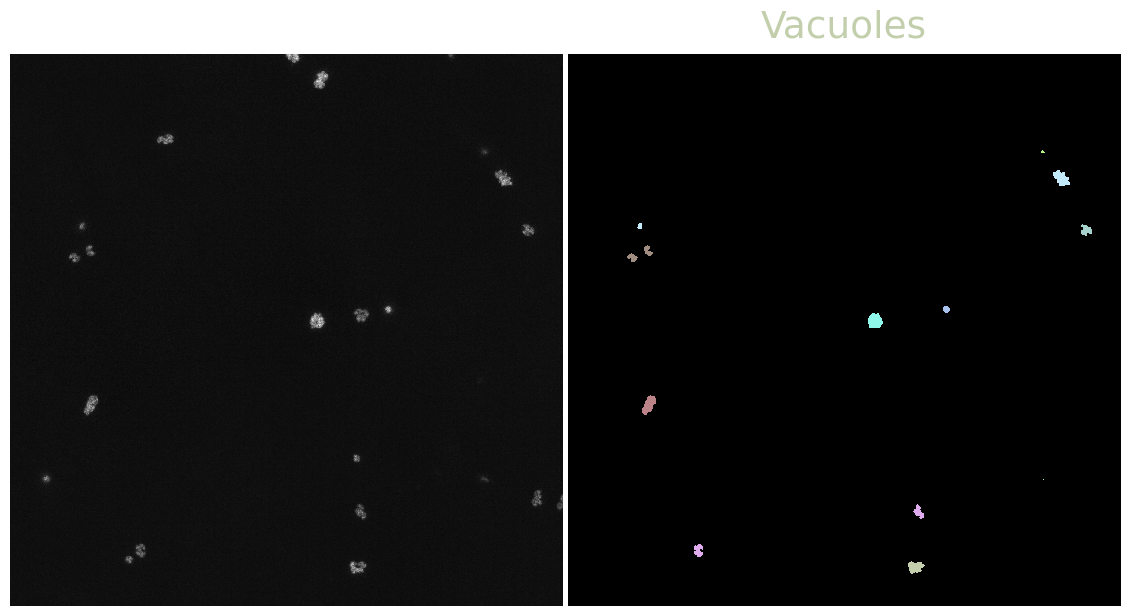

Enhanced visualization with cell boundaries, vacuole boundaries, and detected peaks:


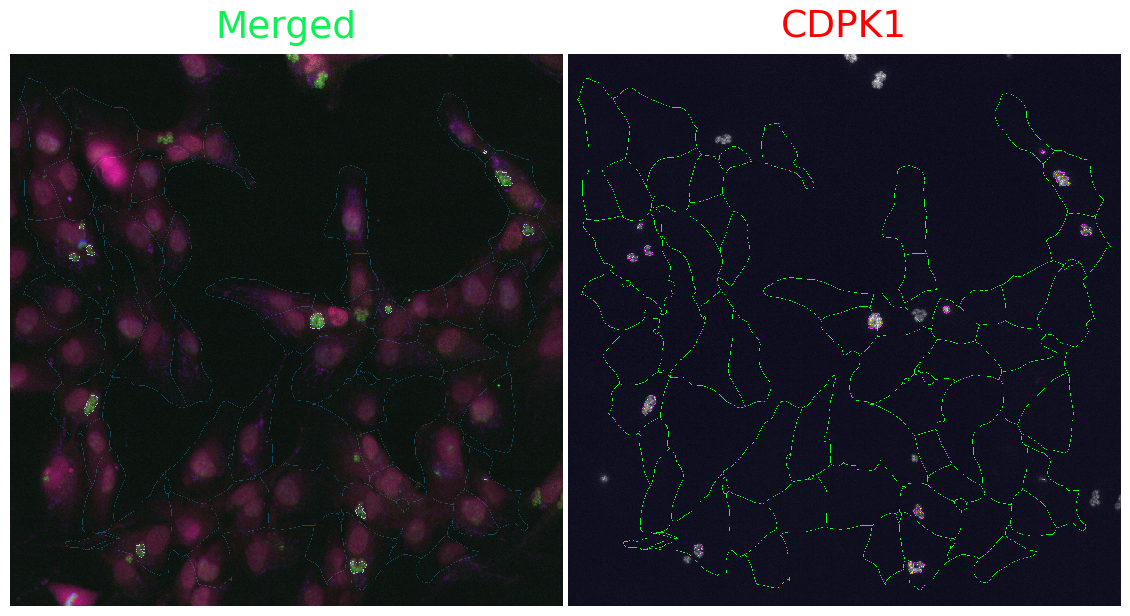

In [13]:
# Segment vacuoles if enabled
if VACUOLE_DETECTION:
    print(f"Performing vacuole segmentation with {VACUOLE_CHANNEL}...")
    
    vacuole_masks, cell_vacuole_table, updated_cytoplasm_masks = segment_vacuoles(
        image=corrected_image,
        vacuole_channel_index=VACUOLE_CHANNEL_INDEX,
        nuclei_channel_index=VACUOLE_CHANNEL_INDEX, 
        cell_masks=cells,
        cytoplasm_masks=cytoplasms,
        min_size=VACUOLE_MIN_SIZE,
        max_size=VACUOLE_MAX_SIZE,
        nuclei_min_distance=5,
        nuclei_centroids=phenotype_minimal
    )
    cell_summary = cell_vacuole_table['cell_summary']
    vacuole_cell_mapping = cell_vacuole_table['vacuole_cell_mapping']
    
    # Print statistics
    print(f"Found vacuoles in {cell_summary['has_vacuole'].sum()} out of {len(cell_summary)} cells")
    print(f"Average vacuoles per cell with vacuoles: {cell_summary.loc[cell_summary['has_vacuole'], 'num_vacuoles'].mean():.2f}")
    print(f"Average vacuole area ratio: {cell_summary['vacuole_area_ratio'].mean():.4f}")
    print(f"Total nuclei detected within vacuoles: {cell_summary['total_nuclei_in_vacuoles'].sum()}")
    print(f"Number of multinucleated vacuoles: {cell_summary['multinucleated_vacuole_count'].sum()}")
    
    # Create standard visualizations
    print("Example microplots for vacuole channel and vacuole segmentation:")
    vacuole_cmap = random_cmap(num_colors=len(np.unique(vacuole_masks)))
    vacuole_microimages = [
        Microimage(
            corrected_image[VACUOLE_CHANNEL_INDEX],
            channel_names=VACUOLE_CHANNEL,
            cmaps="gray",
        ),
        Microimage(vacuole_masks, cmaps=vacuole_cmap, channel_names="Vacuoles"),
    ]
    vacuole_panel = create_micropanel(vacuole_microimages, add_channel_label=True)
    plt.show()
    
    # Create enhanced boundary visualization with peaks
    print("Enhanced visualization with cell boundaries, vacuole boundaries, and detected peaks:")
    boundary_panel = create_vacuole_boundary_visualization(
        corrected_image,
        VACUOLE_CHANNEL_INDEX,
        cell_masks=cells,
        vacuole_masks=vacuole_masks,
        vacuole_cell_mapping=vacuole_cell_mapping,
        channel_names=CHANNEL_NAMES,
        show_nuclei_peaks=True
    )
    plt.show()

In [14]:
# Extract the two DataFrames from the dictionary
cell_summary_df = cell_vacuole_table['cell_summary']
vacuole_cell_mapping_df = cell_vacuole_table['vacuole_cell_mapping']

# Display the cell summary DataFrame
print("Cell Summary DataFrame:")
display(cell_summary_df)

# Display the vacuole-cell mapping DataFrame
print("\nVacuole-Cell Mapping DataFrame:")
display(vacuole_cell_mapping_df)

Cell Summary DataFrame:


cell_id  has_vacuole  num_vacuoles vacuole_ids  cell_area  \
0         1        False             0          []      57911   
1         2        False             0          []      80613   
2         3         True             1         [4]      33374   
3         4        False             0          []      26695   
4         5        False             0          []       9333   
5         6        False             0          []      41325   
6         7         True             1         [5]      46341   
7         8        False             0          []      24204   
8         9        False             0          []      35217   
9        10        False             0          []      51089   
10       11        False             0          []      26569   
11       12        False             0          []      25180   
12       13        False             0          []      59365   
13       14        False             0          []      28527   
14       15         True             3   [6, 8, 9]      88784   
15       16         True             1         [7]      43644   
16       17        False             0          []      22430   
17       18        False             0          []      45115   
18       19        False             0          []      57610   
19       20        False             0          []      43645   
20       21        False             0          []      45430   
21       22        False             0          []      25106   
22       23        False             0          []      72770   
23       24        False             0          []      24963   
24       25         True             1        [10]      28280   
25       26         True             1        [12]      36272   
26       27        False             0          []      44874   
27       28        False             0          []      51382   
28       29        False             0          []      46857   
29       30        False             0          []      71385   
30       31        False             0          []      45041   
31       32        False             0          []      44922   
32       33         True             1        [13]      44504   
33       34        False             0          []      49216   
34       35        False             0          []      54260   
35       36        False             0          []      54289   
36       37        False             0          []      79142   
37       38        False             0          []      67263   
38       39        False             0          []      22549   
39       40        False             0          []      18744   
40       41         True             1        [16]      43140   
41       42        False             0          []      41298   
42       43        False             0          []      78003   
43       44        False             0          []      24876   
44       45         True             1        [20]      75115   
45       46        False             0          []      48008   
46       47         True             1        [19]      42075   
47       48        False             0          []      27780   
48       49        False             0          []      39306   
49       50        False             0          []      47761   
50       51         True             1        [22]      43737   
51       52        False             0          []      34213   
52       53        False             0          []      32768   
53       54        False             0          []      24571   

    total_vacuole_area  vacuole_area_ratio  total_nuclei_in_vacuoles  \
0                    0            0.000000                         0   
1                    0            0.000000                         0   
2                  129            0.003865                         1   
3                    0            0.000000                         0   
4                    0            0.000000                         0


Vacuole-Cell Mapping DataFrame:


vacuole_id  cell_id  vacuole_area  overlap_ratio  nuclei_count  \
0            4        3           129       1.000000             1   
1            5        7          3241       1.000000            13   
2            6       15           429       1.000000             3   
3            7       16          1675       1.000000             9   
4            8       15          1021       1.000000             4   
5            9       15          1059       1.000000             5   
6           10       25           755       1.000000             2   
7           12       26          3436       0.692957            15   
8           13       33          3150       1.000000            14   
9           16       41            21       1.000000             1   
10          19       47          1565       1.000000             7   
11          20       45          1591       1.000000            12   
12          22       51          2805       0.668806            12   

                                     peak_coordinates  distance_to_nucleus  \
0                                       [[432, 2063]]           104.813380   
1   [[556, 2146], [567, 2141], [546, 2129], [536, ...           114.440552   
2                [[750, 309], [756, 306], [743, 310]]            57.911715   
3   [[766, 2251], [780, 2268], [777, 2236], [775, ...            79.162115   
4    [[841, 344], [865, 355], [855, 345], [856, 336]]            99.239459   
5   [[899, 277], [884, 265], [882, 283], [887, 295...            94.990787   
6                        [[1114, 1645], [1110, 1632]]            79.655881   
7   [[1152, 1316], [1161, 1313], [1153, 1324], [11...            89.610951   
8   [[1524, 344], [1532, 346], [1514, 361], [1532,...            63.078221   
9                                      [[1851, 2067]]            66.945829   
10  [[1994, 1529], [2013, 1536], [1990, 1510], [19...            57.817642   
11  [[2145, 554], [2174, 560], [2170, 552], [2180,...            80.505243   
12  [[2244, 1506], [2233, 1491], [2218, 1486], [22...            96.505132   

    nearest_nucleus_id  
0                    2  
1                    6  
2                   14  
3                   15  
4                   14  
5                   14  
6                   24  
7                   23  
8                   32  
9                   40  
10                  46  
11                  44  
12                  51

In [15]:
print("Extracting phenotype features:")
phenotype_cp = extract_phenotype_cp_multichannel(
    aligned_image,
    nuclei=nuclei,
    cells=cells,
    wildcards=WILDCARDS,
    cytoplasms=cytoplasms,
    foci_channel=FOCI_CHANNEL,
    channel_names=CHANNEL_NAMES,
)

phenotype_cp

Extracting phenotype features:


label  nucleus_DAPI_int  nucleus_ConA_int  nucleus_Mitotracker_int  \
0       1          11897900           1407398                  1482422   
1       2           9864038           1325332                  1693174   
2       3           5466822           1604974                  1430947   
3       4           6063950           1461083                  1355360   
4       5           6267005           1265412                  1174472   
5       6           6496455           1264302                  1371481   
6       7           6452281           2090579                  1863950   
7       8           8751434           1217898                  1346184   
8       9           7893965           1428364                  1312894   
9      10          11815543           1999462                  1877048   
10     11           6141925           1541070                  1172519   
11     12           6587582           1002338                  1061838   
12     13           9876557           1840535                  1897907   
13     14           6564938           1058785                  1308596   
14     15          13980181           2159481                  2205280   
15     16           6421092           1698855                  1594765   
16     17           4788964           1947596                  1399272   
17     18          12919599           2620314                  2119838   
18     19          12605965           2679059                  2034551   
19     20           6326812           1435881                  1419495   
20     21           6193610           1584528                  1685041   
21     22           6348276           2175673                  1261934   
22     23           6784230           1486408                  1767734   
23     24           6297816           2209026                  1508457   
24     25           6879151           2448798                  1928347   
25     26           6174629           1256583                  1274797   
26     27           6263392           1204374                  1291410   
27     28           7874926           1605824                  1649888   
28     29           6720669           2069121                  1662367   
29     30          11543329           2318444                  2243829   
30     31           8526028           1824151                  1681946   
31     32           6475236           1763213                  1457405   
32     33           6415626           1544143                  1491782   
33     34           6165786           1248077                  1109884   
34     35          12553629           1993084                  2099656   
35     36           8393055           1430723                  1582155   
36     37          12935400           1906955                  2168359   
37     38           8036339           3739570                  3038541   
38     39           6386751           1157999                  1067306   
39     40           6065367           1681911                  1180000   
40     41           6205179           1891613                  1354982   
41     42           6467778           1195842                  1265739   
42     43          12081810           1833426                  2070534   
43     44           6371517           2765443                  1863475   
44     45           7328445           1722489                  1822965   
45     46          12767469           2691308                  2655168   
46     47           6427697           1247988                  1393713   
47     48          12340278           2484889                  2173394   
48     49           6490326           1545163                  1454203   
49     50           8209631           1976735                  1533404   
50     51           6601752           1425631                  1665063   
51     52           3835380           1041424                   890350   
52     53          11212734           1624386                  1657309   
53     5

In [16]:
# Extract phenotype features for vacuoles
vacuole_phenotype = extract_phenotype_vacuoles(
    aligned_image,
    vacuoles=vacuole_masks,
    vacuole_cell_mapping_df=cell_vacuole_table['vacuole_cell_mapping'],
    wildcards=WILDCARDS,
    foci_channel=FOCI_CHANNEL, 
    channel_names=CHANNEL_NAMES
)

In [17]:
vacuole_phenotype

vacuole_id  cell_id  vacuole_area_x  overlap_ratio  nuclei_count  \
0            4        3             129       1.000000             1   
1            5        7            3241       1.000000            13   
2            6       15             429       1.000000             3   
3            7       16            1675       1.000000             9   
4            8       15            1021       1.000000             4   
5            9       15            1059       1.000000             5   
6           10       25             755       1.000000             2   
7           12       26            3436       0.692957            15   
8           13       33            3150       1.000000            14   
9           16       41              21       1.000000             1   
10          19       47            1565       1.000000             7   
11          20       45            1591       1.000000            12   
12          22       51            2805       0.668806            12   

                                     peak_coordinates  distance_to_nucleus  \
0                                       [[432, 2063]]           104.813380   
1   [[556, 2146], [567, 2141], [546, 2129], [536, ...           114.440552   
2                [[750, 309], [756, 306], [743, 310]]            57.911715   
3   [[766, 2251], [780, 2268], [777, 2236], [775, ...            79.162115   
4    [[841, 344], [865, 355], [855, 345], [856, 336]]            99.239459   
5   [[899, 277], [884, 265], [882, 283], [887, 295...            94.990787   
6                        [[1114, 1645], [1110, 1632]]            79.655881   
7   [[1152, 1316], [1161, 1313], [1153, 1324], [11...            89.610951   
8   [[1524, 344], [1532, 346], [1514, 361], [1532,...            63.078221   
9                                      [[1851, 2067]]            66.945829   
10  [[1994, 1529], [2013, 1536], [1990, 1510], [19...            57.817642   
11  [[2145, 554], [2174, 560], [2170, 552], [2180,...            80.505243   
12  [[2244, 1506], [2233, 1491], [2218, 1486], [22...            96.505132   

    nearest_nucleus_id  vacuole_DAPI_int  vacuole_ConA_int  ...  tile  well  \
0                    2             17776             47178  ...     1    A1   
1                    6            469775            956723  ...     1    A1   
2                   14            183465            125371  ...     1    A1   
3                   15            236618            354791  ...     1    A1   
4                   14            169586            187440  ...     1    A1   
5                   14            162593            196059  ...     1    A1   
6                   24            117142            269915  ...     1    A1   
7                   23            497107            905377  ...     1    A1   
8                   32            498881            606171  ...     1    A1   
9                   40              3127              5644  ...     1    A1   
10                  46            228416            315852  ...     1    A1   
11                  44            223913            244476  ...     1    A1   
12                  51            395024            509542  ...     1    A1   

    vacuole_CDPK1_foci_count  vacuole_CDPK1_foci_area  \
0                          0                        0   
1                          0                        0   
2                          0                        0   
3                          0                        0   
4                          0                        0   
5                          0                        0   
6                          0                        0   
7                          0                        0   
8                          0                        0   
9                          0                        0   
10                         0                        0   
11                         0                        0   
12                         0                        0 

In [18]:
# Remove channel names from feature names
def remove_channel_name(feature, channels):
    for channel in channels:
        feature = feature.replace(f"_{channel}", "")
    return feature


# Remove label, well, tile and isolate remaining feature names
filtered_features = [
    feature
    for feature in phenotype_cp.columns.tolist()
    if feature not in ["label", "well", "tile"]
]

# Apply the function to remove channel names
feature_types = [
    remove_channel_name(feature, CHANNEL_NAMES) for feature in filtered_features
]

# Get unique feature types
unique_feature_types = sorted(set(feature_types))

print("Unique feature types:")
unique_feature_types

Unique feature types:


['cell_K',
 'cell_angle_between_neighbors',
 'cell_area',
 'cell_bounds_0',
 'cell_bounds_1',
 'cell_bounds_2',
 'cell_bounds_3',
 'cell_center_mass_c',
 'cell_center_mass_r',
 'cell_centroid_c',
 'cell_centroid_r',
 'cell_compactness',
 'cell_convex_area',
 'cell_correlation',
 'cell_eccentricity',
 'cell_euler_number',
 'cell_extent',
 'cell_first_neighbor_distance',
 'cell_foci_area',
 'cell_foci_count',
 'cell_form_factor',
 'cell_frac_at_d_0',
 'cell_frac_at_d_1',
 'cell_frac_at_d_2',
 'cell_frac_at_d_3',
 'cell_haralick_5_0',
 'cell_haralick_5_1',
 'cell_haralick_5_10',
 'cell_haralick_5_11',
 'cell_haralick_5_12',
 'cell_haralick_5_2',
 'cell_haralick_5_3',
 'cell_haralick_5_4',
 'cell_haralick_5_5',
 'cell_haralick_5_6',
 'cell_haralick_5_7',
 'cell_haralick_5_8',
 'cell_haralick_5_9',
 'cell_hu_moments_0',
 'cell_hu_moments_1',
 'cell_hu_moments_2',
 'cell_hu_moments_3',
 'cell_hu_moments_4',
 'cell_hu_moments_5',
 'cell_hu_moments_6',
 'cell_i',
 'cell_int',
 'cell_int_edge',

## Add phenotype process parameters to config file

The `mode` parameter in the config file determines how Snakemake will execute parameter searches for segmentation optimization. Setting the `mode` to `segment_phenotype_paramsearch` will systematically explore combinations of:

1. Size Parameters:
   - `nuclei_diameter`: Expected diameter of cell nuclei
   - `cell_diameter`: Expected diameter of cell cytoplasm
   
2. CellPose Parameters:
   - `flow_threshold`: Controls sensitivity of segmentation boundaries (default value 0.4)
     - Lower values: More aggressive segmentation, may over-segment
     - Higher values: More conservative, may miss cell boundaries
   - `cellprob_threshold`: Controls cell detection confidence (default value 0)
     - Lower values: Detects more potential cells, may include false positives
     - Higher values: More stringent detection, may miss weaker signals

The parameter search will:
1. Generate segmentations using different parameter combinations
2. Save results for each combination
3. Allow you to visually inspect results to choose optimal values
4. Help identify the best balance between over- and under-segmentation

Running these parameter searches is a time and resource intensive process and should only be done on a small subset of the tiles in the dataset.

In [20]:
# Add phenotype section
config["phenotype"] = {
    "foci_channel": FOCI_CHANNEL,
    "channel_names": CHANNEL_NAMES,
    "align": ALIGN,
    "dapi_index": DAPI_INDEX,
    "cyto_index": CYTO_INDEX,
    "method": SEGMENTATION_METHOD,
    "reconcile": RECONCILE,
    "gpu": GPU,
    "mode": None,
}

# Add method-specific parameters based on segmentation method
if SEGMENTATION_METHOD == "cellpose":
    config["phenotype"].update({
        "nuclei_diameter": NUCLEI_DIAMETER,
        "cell_diameter": CELL_DIAMETER,
        "flow_threshold": FLOW_THRESHOLD,
        "cellprob_threshold": CELLPROB_THRESHOLD,
        "cyto_model": CELLPOSE_MODEL,
    })
elif SEGMENTATION_METHOD == "microsam":
    config["phenotype"].update({
        "microsam_model": MICROSAM_MODEL,
        "points_per_side": POINTS_PER_SIDE,
        "points_per_batch": POINTS_PER_BATCH,
        "stability_score_thresh": STABILITY_SCORE_THRESH,
        "pred_iou_thresh": PRED_IOU_THRESH,
    })
elif SEGMENTATION_METHOD == "stardist":
    config["phenotype"].update({
        "stardist_model": STARDIST_MODEL,
        "prob_thresh": PROB_THRESH,
        "nms_thresh": NMS_THRESH,
    })

if ALIGN:
    config["phenotype"]["target"] = TARGET_INDEX
    config["phenotype"]["source"] = SOURCE_INDEX
    config["phenotype"]["riders"] = RIDER_INDEXES
    config["phenotype"]["remove_channel"] = REMOVE_CHANNEL

if VACUOLE_DETECTION:
    config["phenotype"].update({
        "vacuole_detection": VACUOLE_DETECTION,
        "vacuole_channel_index": VACUOLE_CHANNEL_INDEX,
        "vacuole_min_size": VACUOLE_MIN_SIZE,
        "vacuole_max_size": VACUOLE_MAX_SIZE,
    })

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-style comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False)